In [38]:
import ee
import shapely
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def ee_array_to_df(arr, list_of_bands):
    '''
    Transforms client-side Earth Engine ee.Image.getRegion array to pandas.DataFrame.

    Parameters:
    - arr (list): The array obtained from ee.Image.getRegion on the client-side.
    - list_of_bands (list): A list of band names to be included in the DataFrame.

    Returns:
    pandas.DataFrame: A DataFrame containing longitude, latitude, time, datetime,
                     and the specified bands, with NaN values and unnecessary columns removed.
    '''
    
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [75]:
def ee_sentinel5p_get_data(par, i_date, f_date, scale, u_poi):
    '''
    Retrieves Sentinel-5P (TROPOMI) data for a specified parameter and region.

    Parameters:
    - par (str): The parameter of interest (e.g., 'CO', 'NO2', 'SO2').
    - i_date (str): The start date in 'YYYY-MM-DD' format.
    - f_date (str): The end date in 'YYYY-MM-DD' format.
    - scale (int): The scale for data retrieval.
    - u_poi (ee.Geometry.Point): The Earth Engine point representing the urban area of interest.

    Returns:
    pandas.DataFrame: A DataFrame containing time, datetime, and the specified parameter values.
    '''
    
    parameter = 'COPERNICUS/S5P/NRTI/L3_' + par
    col = ee.ImageCollection('COPERNICUS/S5P/NRTI/L3_'+par)
    valparameter = par + '_column_number_density'
    print(valparameter)
    par_val = col.select(valparameter).filterDate(i_date, f_date)

    # Get the data for the pixel intersecting the point in urban area.
    par_val_u_poi = par_val.getRegion(u_poi, scale).getInfo()
    par_df = ee_array_to_df(par_val_u_poi,[par +'_column_number_density']).reset_index(drop=True)
    return par_df

In [76]:
# Trigger the authentication flow.
ee.Authenticate()

True

In [77]:
# Initialize the library.
ee.Initialize(project='my-project')

In [121]:
# Specify the path to your GeoJSON file
geojson_file_path = './athens-gas_plant.geojson'

with open(geojson_file_path, 'r') as geojson_file:
    geojson_data = json.load(geojson_file)

# Extract geometry from GeoJSON
geometry = shapely.geometry.shape(geojson_data['features'][0]['geometry'])
print(geometry.coords[0])

(23.61023, 37.95429)


In [85]:
ls = ["CO","SO2" ,"NO2"] 

In [112]:
# Initial date of interest (inclusive).
i_date = '2020-01-01'
# Final date of interest (exclusive).
f_date = '2023-01-01'
u_poi = ee.Geometry.Point(geometry.coords[0])
scale = 1000 #meters

emmisions_ls_df = []
for gas in ls:
    emmisions_ls_df.append(ee_sentinel5p_get_data(gas, i_date, f_date, scale, u_poi))

CO_column_number_density
SO2_column_number_density
NO2_column_number_density


In [122]:
# Convert 'datetime' to date
for df in emmisions_ls_df:
    df['datetime'] = pd.to_datetime(df['datetime']).dt.date

# Perform inner joins based on 'datetime'
result = pd.merge(emmisions_ls_df[0], emmisions_ls_df[1], on='datetime', how='inner')
result = pd.merge(result, emmisions_ls_df[2], on='datetime', how='inner')
result = result.drop_duplicates(subset=['datetime'])
result = result.loc[:, ~result.columns.str.contains('time') | (result.columns == 'datetime')]
result = result.reset_index(drop=True)

In [123]:
result

,datetime,CO_column_number_density,SO2_column_number_density,NO2_column_number_density
0,2020-01-22,0.037664,0.000317,0.000184
1,2020-01-25,0.034960,0.001453,0.000131
2,2020-01-28,0.033301,-0.000708,0.000062
3,2020-01-29,0.035220,0.000160,0.000083
4,2020-01-30,0.035534,-0.000467,0.000113
...,...,...,...,...
559,2022-11-10,0.035721,0.000870,0.000320
560,2022-11-13,0.030426,-0.000049,0.000188
561,2022-11-14,0.026322,0.000223,0.000155
562,2022-11-15,0.025766,0.001336,0.000146


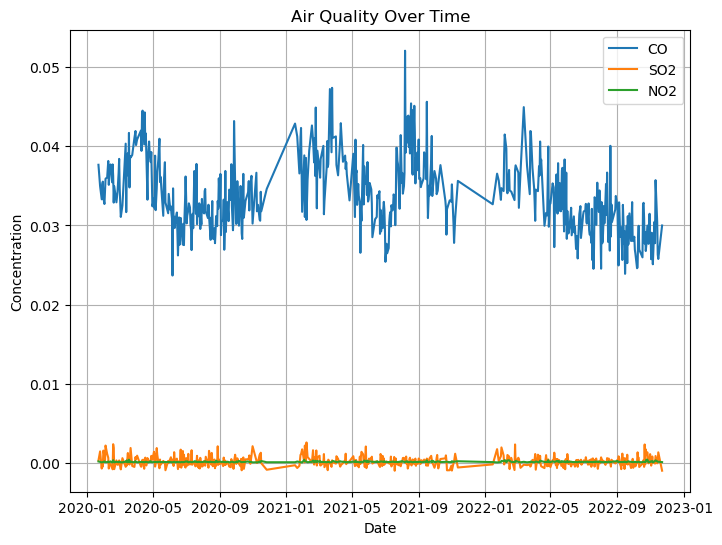

In [124]:

# Assuming your DataFrame is named df
result['datetime'] = pd.to_datetime(result['datetime'])  # Convert 'datetime' column to datetime format

# Plotting
plt.figure(figsize=(8, 6))

plt.plot(result['datetime'], result['CO_column_number_density'], label='CO')
plt.plot(result['datetime'], result['SO2_column_number_density'], label='SO2')
plt.plot(result['datetime'], result['NO2_column_number_density'], label='NO2')

# Customize the plot
plt.title('Air Quality Over Time')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


           CO       SO2       NO2
CO   1.000000 -0.025046  0.164413
SO2 -0.025046  1.000000  0.090409
NO2  0.164413  0.090409  1.000000


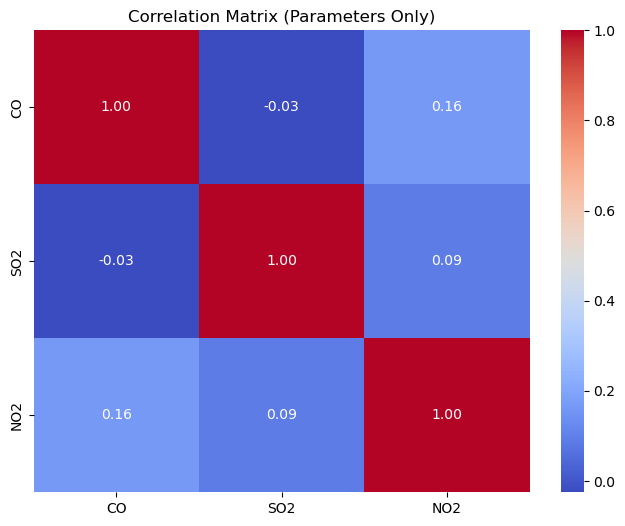

In [125]:
# Assuming your DataFrame is named df
parameters_df = result.drop(columns=['datetime'])  # Exclude the 'datetime' column
parameters_df.columns = ["CO", "SO2", "NO2"]
correlation_matrix = parameters_df.corr()

# Display the correlation matrix
print(correlation_matrix)

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Customize the plot
plt.title('Correlation Matrix (Parameters Only)')
plt.show()